In [1]:
!pip install geopandas
!pip install descartes
# https://python-visualization.github.io/folium/quickstart.html#Getting-Started
!pip install folium
!pip install mapboxgl

#https://hvplot.holoviz.org/user_guide/Geographic_Data.html
#!pip install hvplot
#!pip install geoviews
%matplotlib inline

     |████████████████████████████████| 962kB 1.4MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 8.7kB/s ta 0:00:01     |█████████████▉                  | 4.7MB 896kB/s eta 0:00:07     |██████████████████▉             | 6.4MB 253kB/s eta 0:00:18��██████████████████████▊        | 8.1MB 717kB/s eta 0:00:04
     |████████████████████████████████| 14.7MB 4.8kB/s eta 0:00:01    |█████▋                          | 2.6MB 90kB/s eta 0:02:15     |█████████                       | 4.2MB 230kB/s eta 0:00:46████████████████▏             | 8.4MB 94kB/s eta 0:01:08��██████████▉       | 11.4MB 3.0MB/s eta 0:00:02████████████████████▍     | 12.1MB 3.0MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 1.7MB/s eta 0:00:01     |██████████████████████████████▏ | 1.7MB 1.7MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip i

Successfully built chroma-py
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
import pandas as pd
import geopandas
import sqlite3
from shapely import wkt
import folium
from mapboxgl.viz import *
from mapboxgl.utils import *


# Must be a public token, starting with `pk`
token = 'pk.eyJ1IjoiY2Ftd2F0c29uIiwiYSI6ImNqZXNwd285bDB5cnAyd212Y3pucjN5YnQifQ.Xj3cN1bUdRebhyJJy2yunQ'

In [3]:
conn = sqlite3.connect('cap_data.db')
#query = "select * from cap_alerts"
#query = "select cap_alerts.refID, cap_alerts.identifier, cap_alerts.sender, cap_alerts.sent, cap_alerts.status, cap_alerts.msgType, cap_alerts.rev_refid, cap_info.infoID, cap_info.expires,cap_info.event,cap_info.category,cap_info.certainty,cap_info.severity,cap_info.headline,cap_info.description,cap_info.instruction,cap_poly.polygon from cap_alerts, cap_info, cap_area, cap_poly where cap_alerts.refID = cap_info.refID and cap_info.refid = cap_area.refID and cap_info.infoid = cap_area.infoID and cap_area.areaDesc = cap_poly.areaDesc and datetime(cap_info.expires) >= datetime('now') ORDER BY cap_info.expires ASC"
query = """select cap_alerts.refID,
	cap_alerts.identifier, 
	cap_alerts.sender, 
	cap_alerts.sent, 
	cap_alerts.status,
	cap_alerts.msgType,
	cap_info.infoID,    
	cap_info.expires,
	cap_info.event,
	cap_info.category,
	cap_info.responseType,
	cap_info.certainty,
	cap_info.severity,
	cap_info.urgency,
	cap_info.headline,
	cap_info.description,
	cap_info.instruction,
	cap_poly.polygon,
	cap_alerts.rev_refID
	from cap_alerts, cap_info, cap_area, cap_poly 
	where cap_alerts.refID = cap_info.refID 
	and cap_info.refid = cap_area.refID 
	and cap_info.infoid = cap_area.infoID 
	and cap_area.areaDesc = cap_poly.areaDesc
	and datetime(cap_info.expires) >= datetime('now')
	and rev_refID is NULL
	ORDER BY cap_alerts.sent DESC
"""
df = pd.read_sql_query(query,conn)


In [4]:
#df.head()

In [5]:
# Convert WKT data in polygon column to shapely format for gdf
df['polygon'] = df['polygon'].apply(wkt.loads)
#df.head()

In [6]:
# Create GeoDataFrame
gdf = geopandas.GeoDataFrame(df, geometry='polygon')

In [7]:
# Dissolve data based on ID and info_count 
#gdf = gdf.dissolve(by=['identifier', 'infoID'], aggfunc='first')

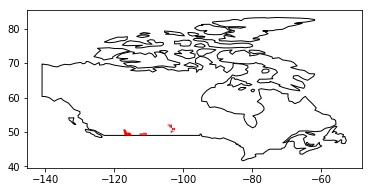

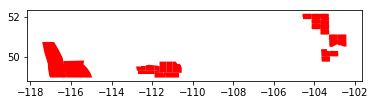

In [8]:
import matplotlib.pyplot as plt

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'Canada'].plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')
gdf.plot(color='red')
plt.show()

In [9]:
gdf.count()

refID           25
identifier      25
sender          25
sent            25
status          25
msgType         25
infoID          25
expires         25
event           25
category        25
responseType    25
certainty       25
severity        25
urgency         25
headline        25
description     25
instruction      8
polygon         25
rev_refID        0
dtype: int64

In [10]:
# Write out to GeoJson file.
gdf.to_file("cdn_alerts.geojson", driver='GeoJSON')

In [11]:
#gdf.to_file("ShapeFiles/cdn_alerts.shp", driver='ESRI Shapefile')

In [12]:
#import fiona
#fiona.supported_drivers

In [ ]:
match_color_stops = [['AllClear', 'rgb(46,204,113)'],
                     ['Monitor', 'rgb(231,76,60)']]

viz = ChoroplethViz("https://raw.githubusercontent.com/camwatson/SpatialDataSets/master/Canada_Alerts_English.geojson", 
                    access_token=token,
                    color_property='responseType', 
                    color_stops=match_color_stops, 
                    color_function_type='match', 
                    color_default='rgba(52,73,94,0.5)', 
                    opacity=0.8, 
                    center=(-96, 55), 
                    zoom=3, 
                    below_layer='waterway-label')
viz.show()



In [14]:
m = folium.Map(
    location=[55, -130],
    zoom_start=2  # Limited levels of zoom for free Mapbox tiles.
)

folium.GeoJson(
    gdf.to_json(),
    name='geojson',
).add_to(m)


In [15]:
m